### Variational Autoencoder

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import os
import glob

import sys
sys.path.append("./src/") 

import mnist_data
import plot_utils

![](https://qph.fs.quoracdn.net/main-qimg-62c793e38456b093cd83fd5476aed596)

In [2]:
# Gaussian as encoder
def gaussian_encoder(x, n_hidden, n_output, keep_prob):
    with tf.variable_scope("gaussian_encoder"):
        # initializers
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)

        # 1st hidden layer
        w0 = tf.get_variable('w0', [x.get_shape()[1], n_hidden], initializer=w_init)
        b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
        h0 = tf.matmul(x, w0) + b0
        h0 = tf.nn.elu(h0)
        h0 = tf.nn.dropout(h0, keep_prob)

        # 2nd hidden layer
        w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
        h1 = tf.matmul(h0, w1) + b1
        h1 = tf.nn.tanh(h1)
        h1 = tf.nn.dropout(h1, keep_prob)

        # output layer                                                                                                                                                                      
        # borrowed from https: // github.com / altosaar / vae / blob / master / vae.py
        wo = tf.get_variable('wo', [h1.get_shape()[1], n_output * 2], initializer=w_init)
        bo = tf.get_variable('bo', [n_output * 2], initializer=b_init)
        gaussian_params = tf.matmul(h1, wo) + bo

        # The mean parameter is unconstrained
        mean = gaussian_params[:, :n_output]
        # The standard deviation must be positive. Parametrize with a softplus and
        # add a small epsilon for numerical stability
        stddev = 1e-6 + tf.nn.softplus(gaussian_params[:, n_output:])

    return mean, stddev



![](https://media.springernature.com/original/springer-static/image/art%3A10.1007%2Fs10115-018-1306-7/MediaObjects/10115_2018_1306_Fig3_HTML.png)

### decoder
- decoder output loss function follows bernoulli distribution 

In [3]:
# Bernoulli as decoder
def bernoulli_decoder(z, n_hidden, n_output, keep_prob, reuse=False):

    with tf.variable_scope("bernoulli_decoder", reuse=reuse):
        # initializers
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)

        # 1st hidden layer
        w0 = tf.get_variable('w0', [z.get_shape()[1], n_hidden], initializer=w_init)
        b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
        h0 = tf.matmul(z, w0) + b0
        h0 = tf.nn.tanh(h0)
        h0 = tf.nn.dropout(h0, keep_prob)

        # 2nd hidden layer
        w1 = tf.get_variable('w1', [h0.get_shape()[1], n_hidden], initializer=w_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=b_init)
        h1 = tf.matmul(h0, w1) + b1
        h1 = tf.nn.elu(h1)
        h1 = tf.nn.dropout(h1, keep_prob)

        # output layer-mean
        wo = tf.get_variable('wo', [h1.get_shape()[1], n_output], initializer=w_init)
        bo = tf.get_variable('bo', [n_output], initializer=b_init)
        y = tf.sigmoid(tf.matmul(h1, wo) + bo)

    return y


### build autoencoder- encoder

## ELBO term
![](https://image.slidesharecdn.com/iaf-170120100642/95/improving-variational-inference-with-inverse-autoregressive-flow-2-638.jpg?cb=1484906842)

![](./pictures/KL_div.png)

![](./pictures/reconstruction_error.png)

![](./pictures/loss_function1.png)

![](./pictures/gaussian_loss.png)

![](./pictures/gaussian+bernoulli.png)

![](./pictures/gaussian_gaussian.png)

![](./pictures/mnist.png)

In [4]:
def autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob):

    # encoding
    mu, sigma = gaussian_encoder(x_hat, n_hidden, dim_z, keep_prob)

    # sampling by re-parameterization technique
    z = mu + sigma * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)

    # decoding
    y = bernoulli_decoder(z, n_hidden, dim_img, keep_prob)
    y = tf.clip_by_value(y, 1e-8, 1 - 1e-8)

    # loss
    marginal_likelihood = tf.reduce_sum(x * tf.log(y) + (1 - x) * tf.log(1 - y), 1)
    KL_divergence = 0.5 * tf.reduce_sum(tf.square(mu) + tf.square(sigma) - tf.log(1e-8 + tf.square(sigma)) - 1, 1)

    marginal_likelihood = tf.reduce_mean(marginal_likelihood)
    KL_divergence = tf.reduce_mean(KL_divergence)

    ELBO = marginal_likelihood - KL_divergence

    loss = -ELBO

    return y, z, loss, -marginal_likelihood, KL_divergence


In [5]:

def decoder(z, dim_img, n_hidden):

    y = bernoulli_decoder(z, n_hidden, dim_img, 1.0, reuse=True)

    return y

### setting parameters

In [6]:
RESULTS_DIR = './results'

# network architecture
ADD_NOISE = True # Denoising Auto encoder

n_hidden = 500

IMAGE_SIZE_MNIST = 28

dim_img = IMAGE_SIZE_MNIST**2  # number of pixels for a MNIST image
dim_z = 2#20 # latent vector size

# train
n_epochs = 20
batch_size = 128
learn_rate = 1e-3

# Plot
PRR = True                           # Plot Reproduce Result
PRR_n_img_x = 10              # number of images along x-axis in a canvas
PRR_n_img_y = 10              # number of images along y-axis in a canvas
PRR_resize_factor = 1.0  # resize factor for each image in a canvas

PMLR = True                            # Plot Manifold Learning Result
PMLR_n_img_x = 20            # number of images along x-axis in a canvas
PMLR_n_img_y = 20            # number of images along y-axis in a canvas
PMLR_resize_factor = 1.0   # resize factor for each image in a canvas
PMLR_z_range = 2.0            # range for random latent vector
PMLR_n_samples = 5000        # number of labeled samples to plot a map from input data space to the latent space


In [7]:
train_total_data, train_size, _, _, test_data, test_labels = mnist_data.prepare_MNIST_data()
n_samples = train_size

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


### build network

In [8]:
# input placeholders
# In denoising-autoencoder, x_hat == x + noise, otherwise x_hat == x
x_hat = tf.placeholder(tf.float32, shape=[None, dim_img], name='input_img')
x = tf.placeholder(tf.float32, shape=[None, dim_img], name='target_img')

# dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# input for PMLR
z_in = tf.placeholder(tf.float32, shape=[None, dim_z], name='latent_variable')

# network architecture
y, z, loss, neg_marginal_likelihood, KL_divergence = autoencoder(x_hat, x, dim_img, dim_z, n_hidden, keep_prob)

# optimization
train_op = tf.train.AdamOptimizer(learn_rate).minimize(loss)


In [9]:
# Plot for reproduce performance
if PRR:
    PRR = plot_utils.Plot_Reproduce_Performance(RESULTS_DIR, PRR_n_img_x, PRR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PRR_resize_factor)

    x_PRR = test_data[0:PRR.n_tot_imgs, :]

    x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
    PRR.save_images(x_PRR_img, name='input.jpg')

    if ADD_NOISE:
        x_PRR = x_PRR * np.random.randint(2, size=x_PRR.shape)
        x_PRR += np.random.randint(2, size=x_PRR.shape)

        x_PRR_img = x_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
        PRR.save_images(x_PRR_img, name='input_noise.jpg')

# Plot for manifold learning result
if PMLR and dim_z == 2:

    PMLR = plot_utils.Plot_Manifold_Learning_Result(RESULTS_DIR, PMLR_n_img_x, PMLR_n_img_y, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST, PMLR_resize_factor, PMLR_z_range)

    x_PMLR = test_data[0:PMLR_n_samples, :]
    id_PMLR = test_labels[0:PMLR_n_samples, :]

    if ADD_NOISE:
        x_PMLR = x_PMLR * np.random.randint(2, size=x_PMLR.shape)
        x_PMLR += np.random.randint(2, size=x_PMLR.shape)

    decoded = decoder(z_in, dim_img, n_hidden)


epoch 0: L_tot 210.73 L_likelihood 203.67 L_divergence 7.06
epoch 1: L_tot 202.02 L_likelihood 195.72 L_divergence 6.30
epoch 2: L_tot 193.94 L_likelihood 190.10 L_divergence 3.85
epoch 3: L_tot 189.42 L_likelihood 184.92 L_divergence 4.49
epoch 4: L_tot 192.40 L_likelihood 188.36 L_divergence 4.04
epoch 5: L_tot 181.20 L_likelihood 176.77 L_divergence 4.43
epoch 6: L_tot 183.95 L_likelihood 179.53 L_divergence 4.42
epoch 7: L_tot 183.11 L_likelihood 178.61 L_divergence 4.50
epoch 8: L_tot 178.87 L_likelihood 174.32 L_divergence 4.55
epoch 9: L_tot 175.58 L_likelihood 170.92 L_divergence 4.66
epoch 10: L_tot 178.97 L_likelihood 174.28 L_divergence 4.69
epoch 11: L_tot 185.92 L_likelihood 180.90 L_divergence 5.02
epoch 12: L_tot 173.62 L_likelihood 168.94 L_divergence 4.68
epoch 13: L_tot 167.93 L_likelihood 162.64 L_divergence 5.29
epoch 14: L_tot 172.59 L_likelihood 167.20 L_divergence 5.39
epoch 15: L_tot 170.79 L_likelihood 165.95 L_divergence 4.84
epoch 16: L_tot 168.42 L_likelihoo

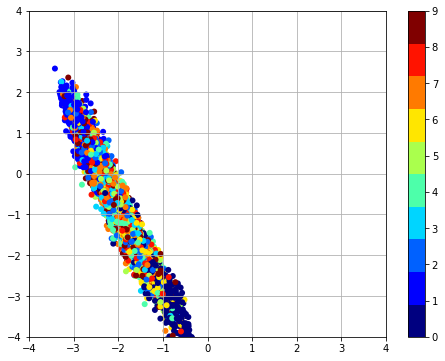

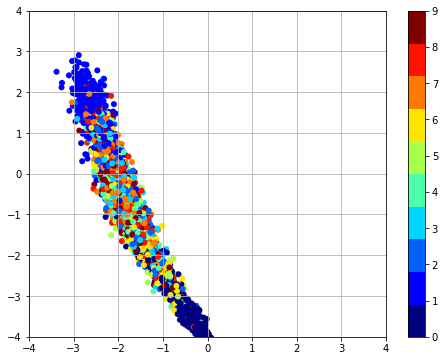

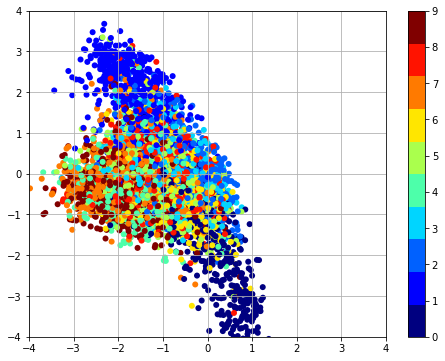

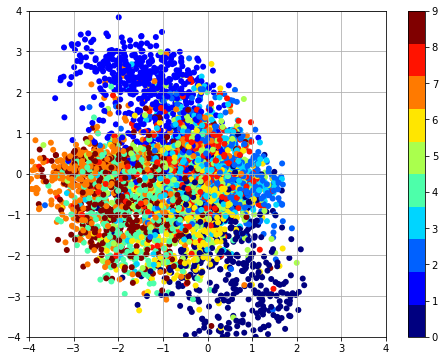

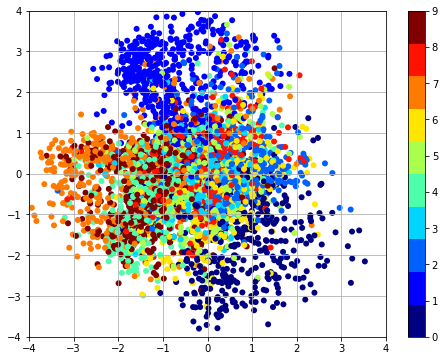

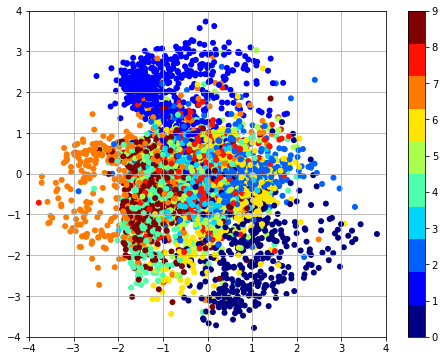

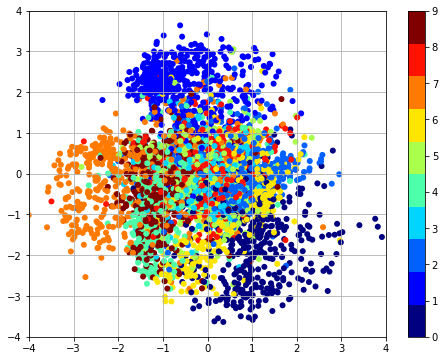

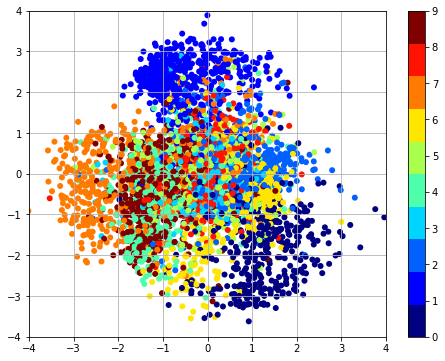

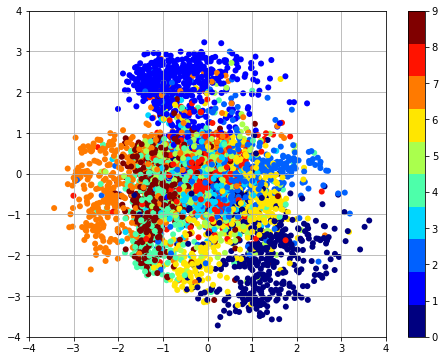

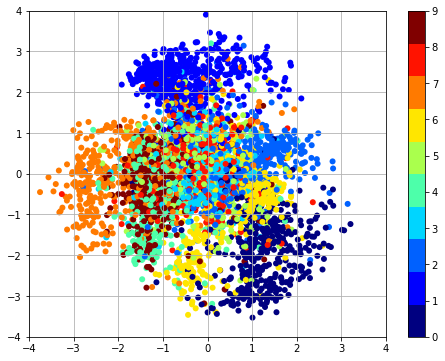

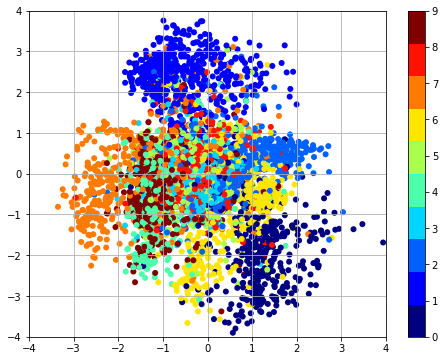

In [11]:

# train
total_batch = int(n_samples / batch_size)
min_tot_loss = 1e99

with tf.Session() as sess:

    sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})

    for epoch in range(n_epochs):

        # Random shuffling
        np.random.shuffle(train_total_data)
        train_data_ = train_total_data[:, :-mnist_data.NUM_LABELS] # (n_samples,784)

        # Loop over all batches
        for i in range(total_batch):
            # Compute the offset of the current minibatch in the data.
            offset = (i * batch_size) % (n_samples)
            batch_xs_input = train_data_[offset:(offset + batch_size), :]

            batch_xs_target = batch_xs_input

            # add salt & pepper noise
            if ADD_NOISE:
                batch_xs_input = batch_xs_input * np.random.randint(2, size=batch_xs_input.shape)
                batch_xs_input += np.random.randint(2, size=batch_xs_input.shape)

            _, tot_loss, loss_likelihood, loss_divergence = sess.run(
                (train_op, loss, neg_marginal_likelihood, KL_divergence),
                feed_dict={x_hat: batch_xs_input, x: batch_xs_target, keep_prob : 0.9})

        # print cost every epoch
        print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f" % (epoch, tot_loss, loss_likelihood, loss_divergence))

        # if minimum loss is updated or final epoch, plot results
        if min_tot_loss > tot_loss or epoch+1 == n_epochs:
            min_tot_loss = tot_loss
            # Plot for reproduce performance
            if PRR:
                y_PRR = sess.run(y, feed_dict={x_hat: x_PRR, keep_prob : 1})
                y_PRR_img = y_PRR.reshape(PRR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
                PRR.save_images(y_PRR_img, name="/PRR_epoch_%02d" %(epoch) + ".jpg")

            # Plot for manifold learning result
            if PMLR and dim_z == 2:
                y_PMLR = sess.run(decoded, feed_dict={z_in: PMLR.z, keep_prob : 1})
                y_PMLR_img = y_PMLR.reshape(PMLR.n_tot_imgs, IMAGE_SIZE_MNIST, IMAGE_SIZE_MNIST)
                PMLR.save_images(y_PMLR_img, name="/PMLR_epoch_%02d" % (epoch) + ".jpg")

                # plot distribution of labeled images
                z_PMLR = sess.run(z, feed_dict={x_hat: x_PMLR, keep_prob : 1})
                PMLR.save_scattered_image(z_PMLR,id_PMLR, name="/PMLR_map_epoch_%02d" % (epoch) + ".jpg")


### Scratch

In [34]:
np.random.randint(2, size=batch_xs_input.shape)[:10]

array([[0, 1, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 1, 1, 0],
       [1, 0, 1, ..., 1, 0, 0]])

In [17]:
train_total_data.shape,test_data.shape,test_labels.shape,mnist_data.NUM_LABELS

((55000, 794), (10000, 784), (10000, 10), 10)

In [35]:
z_range = 2
n_img_y = 10
n_img_x = 10

z = np.rollaxis(np.mgrid[z_range:-z_range:n_img_y * 1j, z_range:-z_range:n_img_x * 1j], 0, 3)

In [37]:
z.shape

(10, 10, 2)

In [39]:
mgrid = np.mgrid[z_range:-z_range:n_img_y * 1j, z_range:-z_range:n_img_x * 1j]
mgrid.shape

(2, 10, 10)

In [49]:
x1, y1 = np.meshgrid(np.arange(1, 6, 2), np.arange(-10, -3, 3))

In [55]:
x1

array([[1, 3, 5],
       [1, 3, 5],
       [1, 3, 5]])

In [51]:
y1.shape

(3, 3)

In [65]:
x2, y2 = np.mgrid[1:11:2, -10:-1:5]

In [72]:
x2,x2.shape

(array([[ 1.,  1.,  1.,  1.,  1.,  1.],
        [11., 11., 11., 11., 11., 11.]]), (2, 6))

In [73]:
y2,y2.shape

(array([[-10. ,  -8.2,  -6.4,  -4.6,  -2.8,  -1. ],
        [-10. ,  -8.2,  -6.4,  -4.6,  -2.8,  -1. ]]), (2, 6))

In [71]:
x2, y2 = np.mgrid[1:11:2j, -10:-1:6j]

[numpy meshgrid mgrid](http://louistiao.me/posts/numpy-mgrid-vs-meshgrid/)  
[mgrid manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mgrid.html)

In [ ]:
# sess = tf.InteractiveSession()

In [14]:
# tmpy = tf.constant(-0.4)
# tmpout = tf.clip_by_value(tmpy, 1e-8, 1 - 1e-8)

# sess.run(tmpout)

1e-08

### references
variational autoencoder from https://github.com/hwalsuklee/tensorflow-mnist-VAE